# Projet 7 : Implémentez un modèle de scoring

## Contexte:

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

## Mission :

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.

## Analyse exploratoire des données

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno


In [29]:
# Training data
app_train = pd.read_csv('application_train_init.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [30]:
# Liste des colonnes
list_col = list(app_train.columns)
print(list_col)

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

In [31]:
# Calcul du nombre de chaque type de colonne
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [32]:
# Copier les colonnes sélectionnées
app_analyse = app_train[['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                         'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                         'OCCUPATION_TYPE']].copy()

# Convertir les jours en positifs
app_analyse['DAYS_BIRTH'] = -app_analyse['DAYS_BIRTH']
app_analyse['DAYS_EMPLOYED'] = -app_analyse['DAYS_EMPLOYED']

# Calculer l'âge
app_analyse['AGE'] = np.round(app_analyse['DAYS_BIRTH'] / 365)

In [33]:
app_analyse.head(15)

TARGET NAME_CONTRACT_TYPE CODE_GENDER  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        1         Cash loans           M        202500.000    406597.5   
1        0         Cash loans           F        270000.000   1293502.5   
2        0    Revolving loans           M         67500.000    135000.0   
3        0         Cash loans           F        135000.000    312682.5   
4        0         Cash loans           M        121500.000    513000.0   
5        0         Cash loans           M         99000.000    490495.5   
6        0         Cash loans           F        171000.000   1560726.0   
7        0         Cash loans           M        360000.000   1530000.0   
8        0         Cash loans           F        112500.000   1019610.0   
9        0    Revolving loans           M        135000.000    405000.0   
10       0         Cash loans           F        112500.000    652500.0   
11       0         Cash loans           F         38419.155    148365.0   
12       0         Cash loans           F         67500.000     80865.0   
13       0         Cash loans           M        225000.000    918468.0   
14       0         Cash loans           F        189000.000    773680.5   

    AMT_ANNUITY      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0       24700.5               Working  Secondary / secondary special   
1       35698.5         State servant               Higher education   
2        6750.0               Working  Secondary / secondary special   
3       29686.5               Working  Secondary / secondary special   
4       21865.5               Working  Secondary / secondary special   
5       27517.5         State servant  Secondary / secondary special   
6       41301.0  Commercial associate               Higher education   
7       42075.0         State servant               Higher education   
8       33826.5             Pensioner  Secondary / secondary special   
9       20250.0               Working  Secondary / secondary special   
10      21177.0               Working               Higher education   
11      10678.5             Pensioner  Secondary / secondary special   
12       5881.5               Working  Secondary / secondary special   
13      28966.5               Working  Secondary / secondary special   
14      32778.0               Working  Secondary / secondary special   

      NAME_FAMILY_STATUS  DAYS_BIRTH  DAYS_EMPLOYED OCCUPATION_TYPE   AGE  
0   Single / not married        9461            637        Laborers  26.0  
1                Married       16765           1188      Core staff  46.0  
2   Single / not married       19046            225        Laborers  52.0  
3         Civil marriage       19005           3039        Laborers  52.0  
4   Single / not married       19932           3038      Core staff  55.0  
5                Married       16941           1588        Laborers  46.0  
6                Married       13778           3130     Accountants  38.0  
7                Married       18850            449        Managers  52.0  
8                Married       20099        -365243             NaN  55.0  
9   Single / not married       14469           2019        Laborers  40.0  
10               Married       10197            679      Core staff  28.0  
11               Married       20417        -365243             NaN  56.0  
12               Married       13439           2717        Laborers  37.0  
13               Married       14086           3028         Drivers  39.0  
14               Married       14583            203        Laborers  40.0

In [34]:
# Sauvegarde de ce fichier à utiliser dans le dashboard
app_analyse.to_csv("df_analyse.csv")

### Analyse du Target

In [41]:
# Analyse du Target

app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

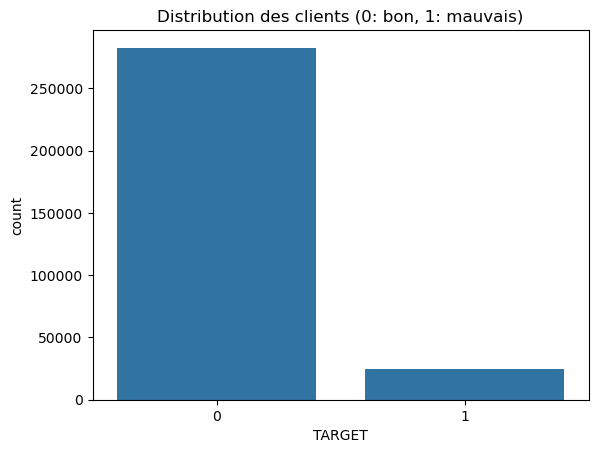

In [42]:
# Distribution de la variable cible
sns.countplot(x='TARGET', data=app_train)
plt.title("Distribution des clients (0: bon, 1: mauvais)")
plt.show()

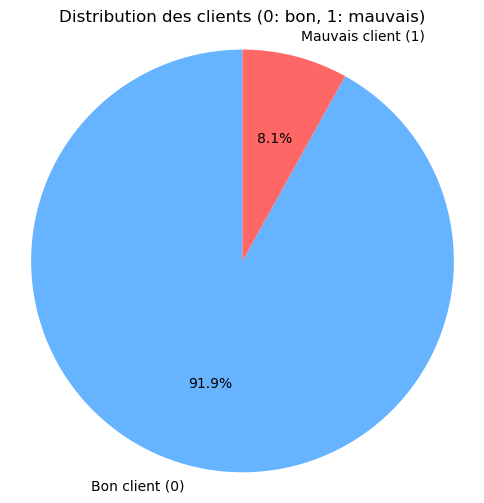

In [43]:
# Calcul des proportions de chaque classe
target_counts = app_train['TARGET'].value_counts()
target_labels = ['Bon client (0)', 'Mauvais client (1)']

# Création du camembert
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title("Distribution des clients (0: bon, 1: mauvais)")
plt.axis('equal')  # Pour garder le cercle rond
plt.show()

### Analyse des valeurs manquantes

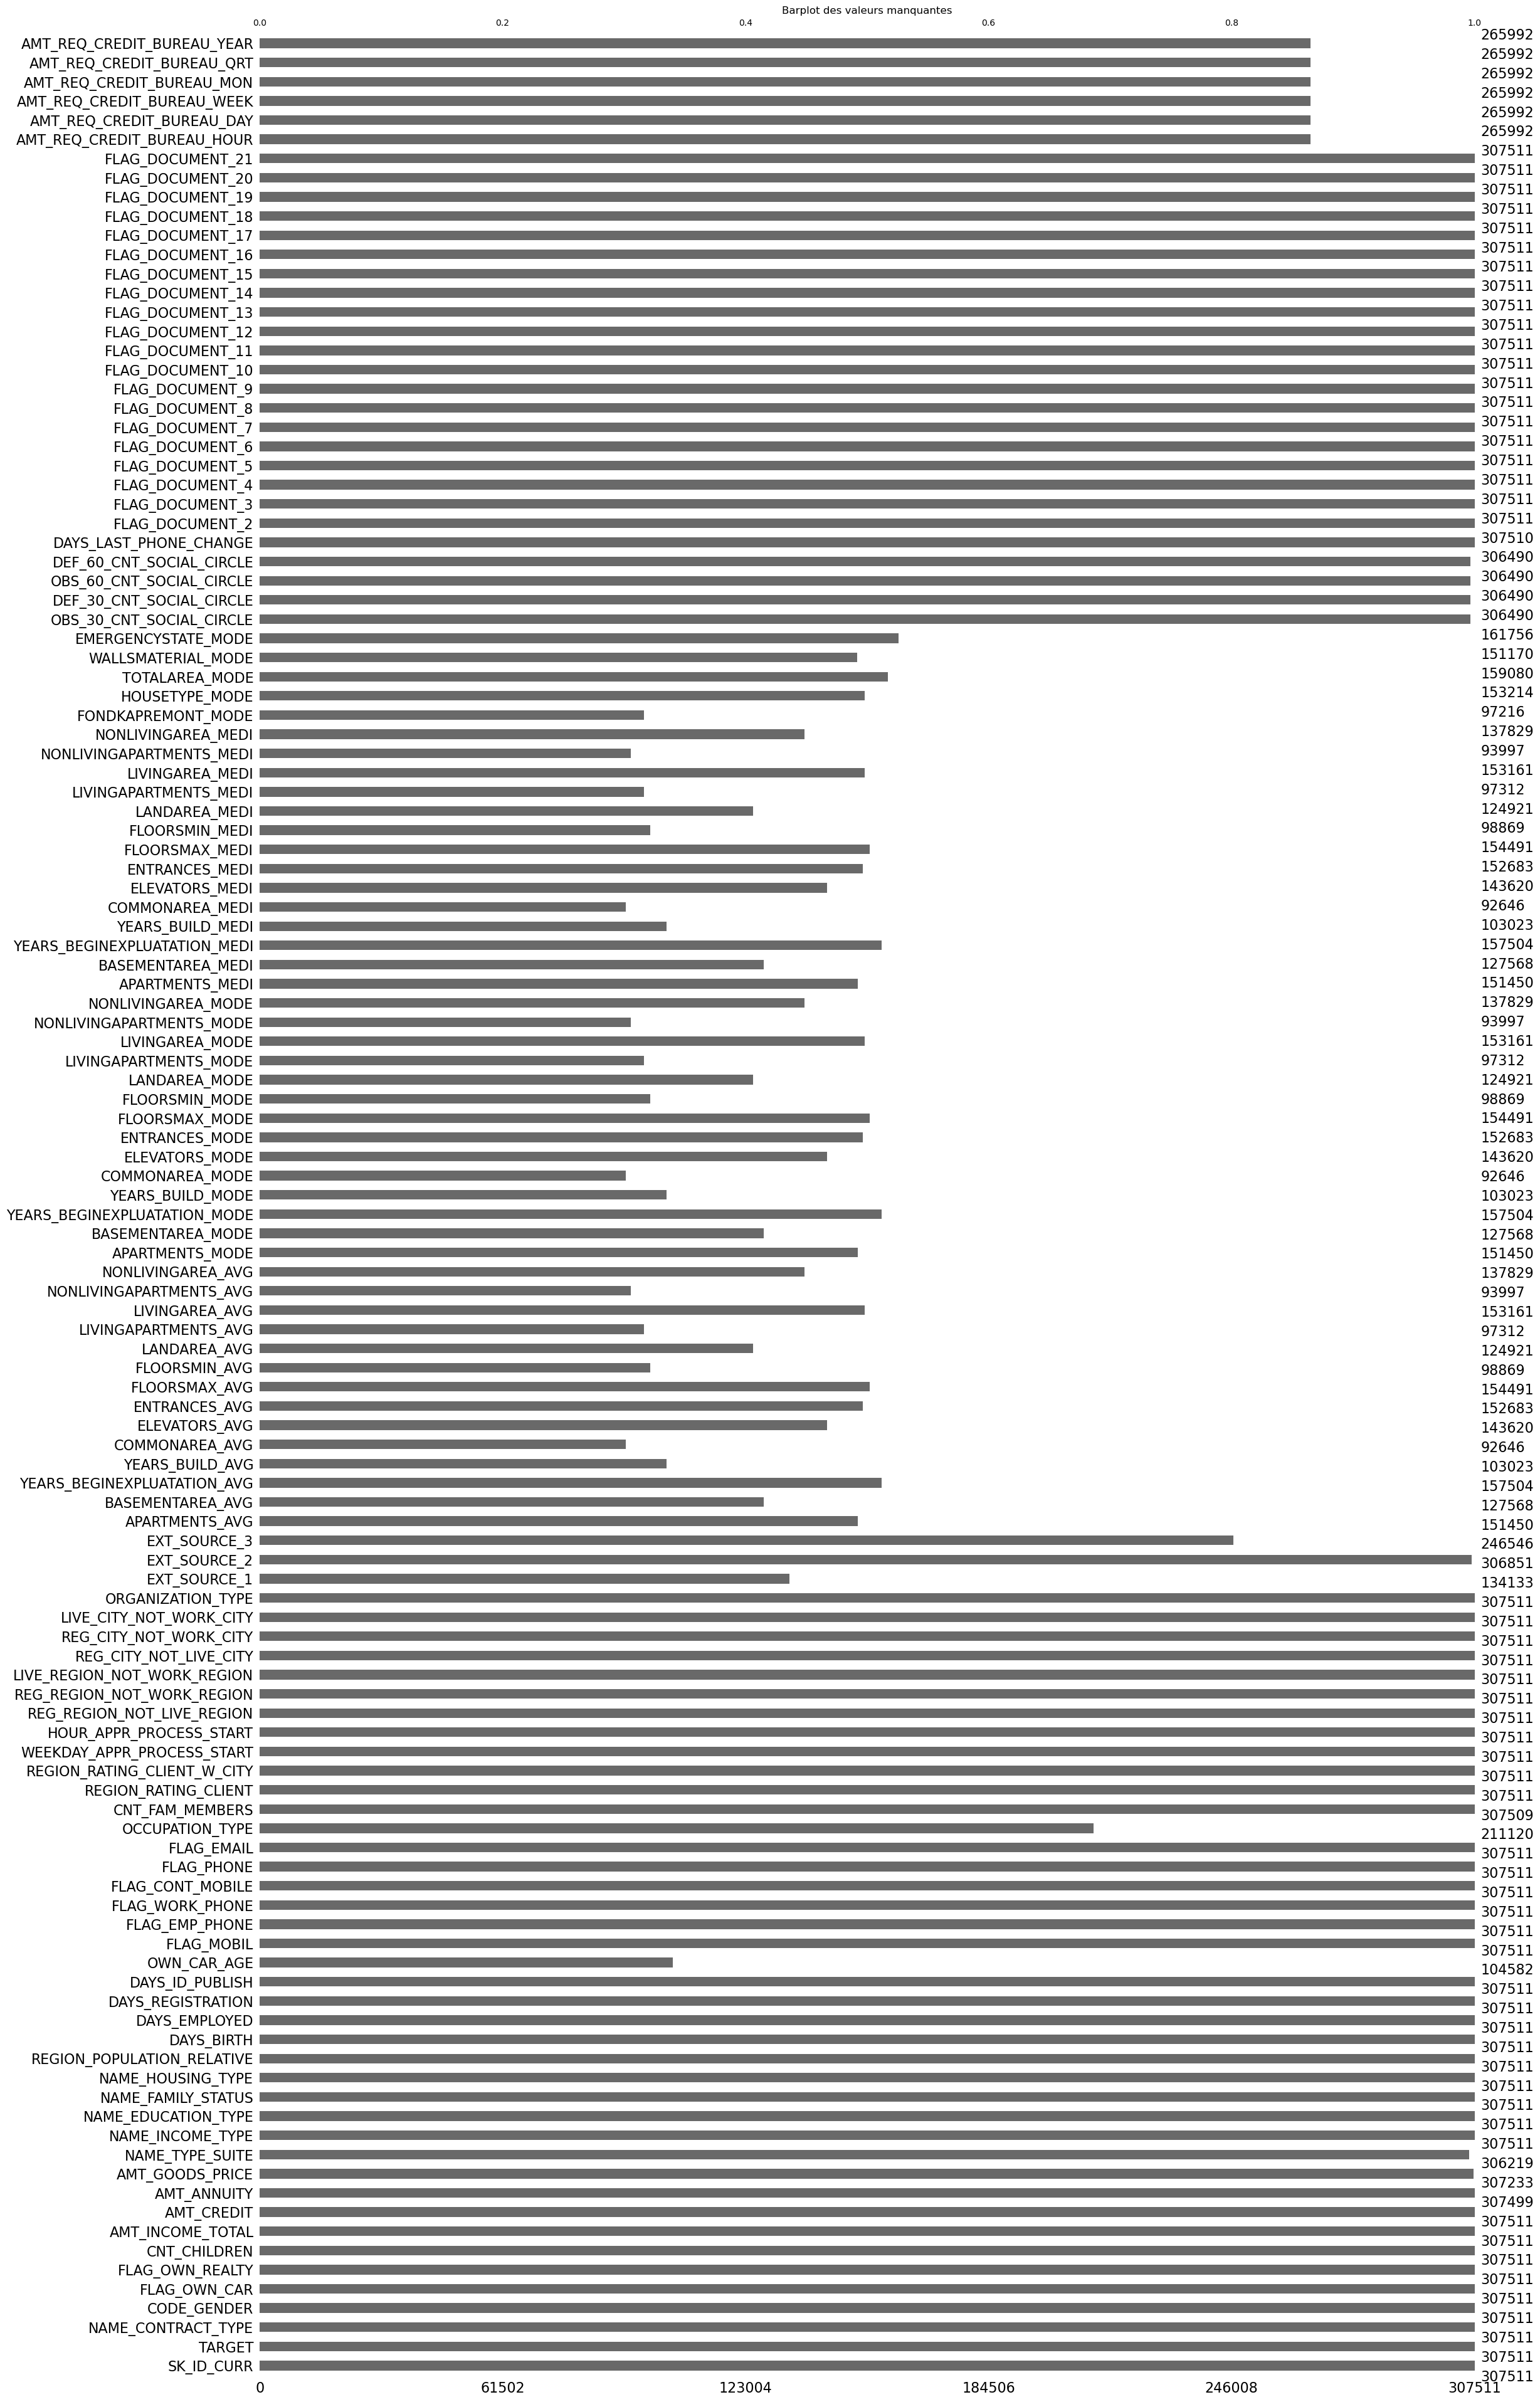

In [47]:

# Visualisation des valeurs manquantes sous forme de barplot
msno.bar(app_train)
plt.title('Barplot des valeurs manquantes')
plt.show()


In [49]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [51]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

In [52]:
missing_values.head(30)

Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4
BASEMENTAREA_MEDI                 179943               58.5
BASEMENTAREA_AVG                  179943               58.5
BASEMENTAREA_MODE                 179943               58.5
EXT_SOURCE_1                      173378               56.4
NONLIVINGAREA_MEDI                169682               55.2
NONLIVINGAREA_MODE                169682               55.2
NONLIVINGAREA_AVG                 169682               55.2
ELEVATORS_MEDI                    163891               53.3
ELEVATORS_MODE                    163891               53.3
ELEVATORS_AVG                     163891               53.3

In [53]:
missing_values.tail(37)

Missing Values  % of Total Values
WALLSMATERIAL_MODE                    156341               50.8
APARTMENTS_MODE                       156061               50.7
APARTMENTS_MEDI                       156061               50.7
APARTMENTS_AVG                        156061               50.7
ENTRANCES_MODE                        154828               50.3
ENTRANCES_AVG                         154828               50.3
ENTRANCES_MEDI                        154828               50.3
LIVINGAREA_MEDI                       154350               50.2
LIVINGAREA_MODE                       154350               50.2
LIVINGAREA_AVG                        154350               50.2
HOUSETYPE_MODE                        154297               50.2
FLOORSMAX_MEDI                        153020               49.8
FLOORSMAX_AVG                         153020               49.8
FLOORSMAX_MODE                        153020               49.8
YEARS_BEGINEXPLUATATION_AVG           150007               48.8
YEARS_BEGINEXPLUATATION_MEDI          150007               48.8
YEARS_BEGINEXPLUATATION_MODE          150007               48.8
TOTALAREA_MODE                        148431               48.3
EMERGENCYSTATE_MODE                   145755               47.4
OCCUPATION_TYPE                        96391               31.3
EXT_SOURCE_3                           60965               19.8
AMT_REQ_CREDIT_BUREAU_WEEK             41519               13.5
AMT_REQ_CREDIT_BUREAU_DAY              41519               13.5
AMT_REQ_CREDIT_BUREAU_MON              41519               13.5
AMT_REQ_CREDIT_BUREAU_QRT              41519               13.5
AMT_REQ_CREDIT_BUREAU_HOUR             41519               13.5
AMT_REQ_CREDIT_BUREAU_YEAR             41519               13.5
NAME_TYPE_SUITE                         1292                0.4
DEF_30_CNT_SOCIAL_CIRCLE                1021                0.3
OBS_60_CNT_SOCIAL_CIRCLE                1021                0.3
DEF_60_CNT_SOCIAL_CIRCLE                1021                0.3
OBS_30_CNT_SOCIAL_CIRCLE                1021                0.3
EXT_SOURCE_2                             660                0.2
AMT_GOODS_PRICE                          278                0.1
AMT_ANNUITY                               12                0.0
CNT_FAM_MEMBERS                            2                0.0
DAYS_LAST_PHONE_CHANGE                     1                0.0

### Analyse des features

In [59]:
# Calcul du nombre de chaque type de colonne
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [60]:
# Nombre de classes uniques dans chaque colonne d'objet
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encodage avec Label Encoding et One Hot Encoding

In [67]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            app_train[col] = le.fit_transform(app_train[col])
            print('transformation colonne label encoding %s.' % col)            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

transformation colonne label encoding NAME_CONTRACT_TYPE.
transformation colonne label encoding FLAG_OWN_CAR.
transformation colonne label encoding FLAG_OWN_REALTY.
3 columns were label encoded.


In [68]:
# one-hot encoding of categorical variables
print('Training Features shape avant : ', app_train.shape)

app_train = pd.get_dummies(app_train)

print('Training Features shape apres : ', app_train.shape)

Training Features shape avant :  (307511, 122)
Training Features shape apres :  (307511, 243)


In [69]:
# Number of each type of column
app_train.dtypes.value_counts()

uint8      134
float64     65
int64       41
int32        3
dtype: int64

### Suite d'AED

In [75]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [77]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [79]:
app_train[app_train['DAYS_EMPLOYED']>0 ][['DAYS_EMPLOYED']]

DAYS_EMPLOYED
8              365243
11             365243
23             365243
38             365243
43             365243
...               ...
307469         365243
307483         365243
307487         365243
307505         365243
307507         365243

[55374 rows x 1 columns]

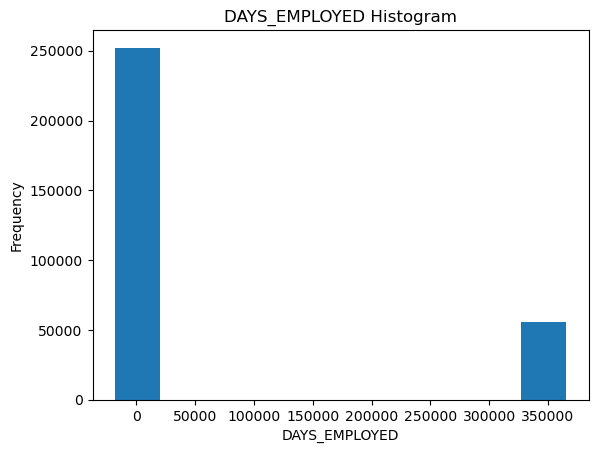

In [81]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'DAYS_EMPLOYED Histogram');
plt.xlabel('DAYS_EMPLOYED');

In [83]:
#singulatite pour 365243
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Defaut paiement pour non anomalie pour %0.2f%% des prets' % (100 * non_anom['TARGET'].mean()))
print('Defaut paiement pour     anomalie pour %0.2f%% des prets' % (100 * anom['TARGET'].mean()))
print('Il y a %d anomalies dans DAYS_EMPLOYED' % len(anom))

Defaut paiement pour non anomalie pour 8.66% des prets
Defaut paiement pour     anomalie pour 5.40% des prets
Il y a 55374 anomalies dans DAYS_EMPLOYED


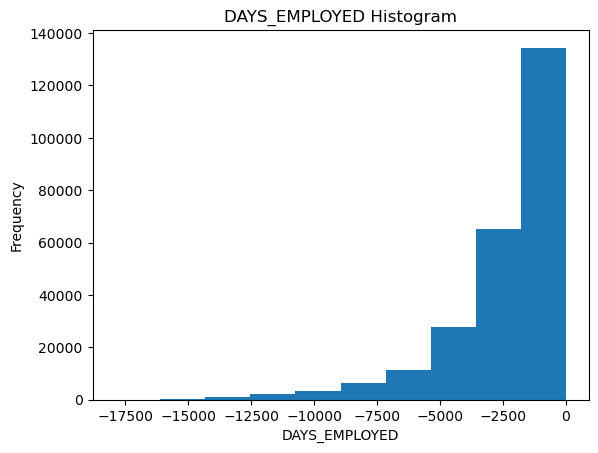

In [85]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = ( app_train["DAYS_EMPLOYED"] == 365243 )

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'DAYS_EMPLOYED Histogram');
plt.xlabel('DAYS_EMPLOYED');

### Etude de corrélation

In [88]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### DAYS_BIRTH

In [90]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982692

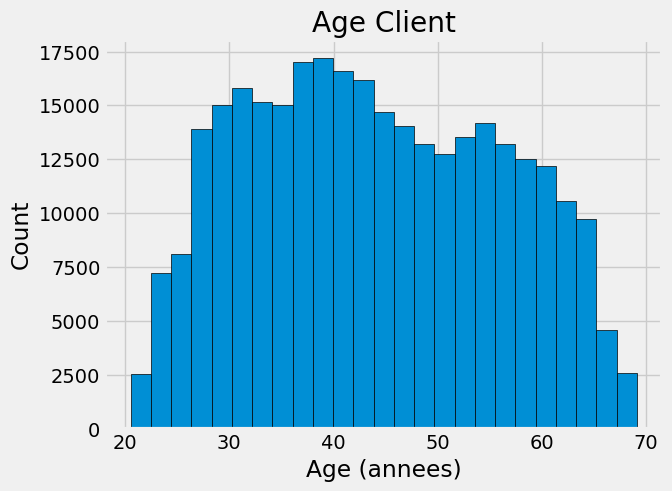

In [91]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age Client'); plt.xlabel('Age (annees)'); plt.ylabel('Count');

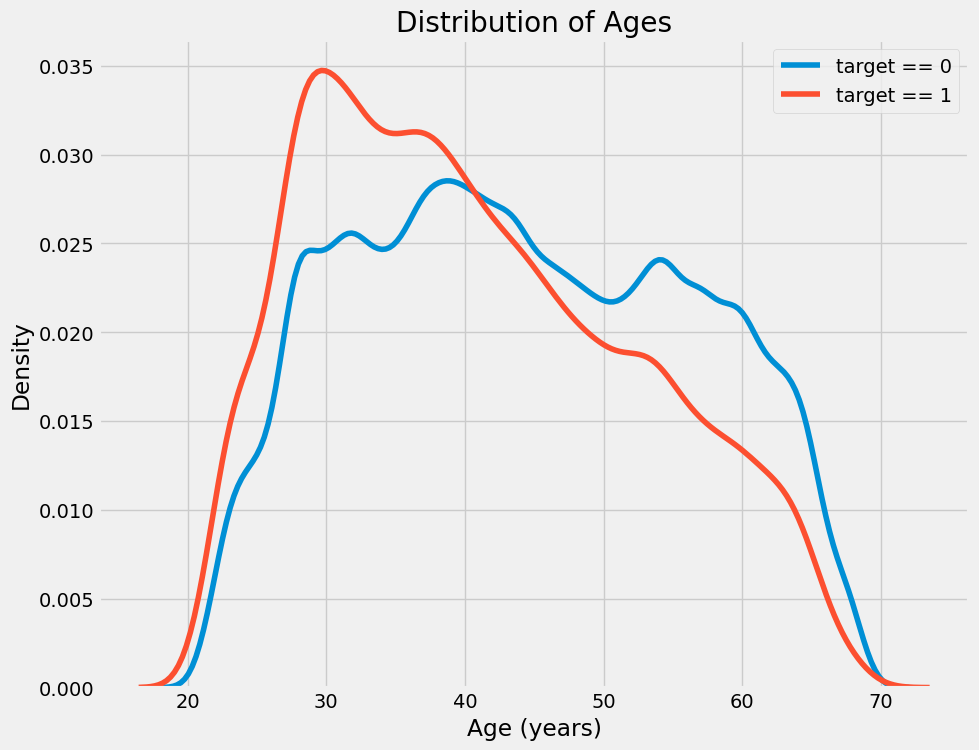

In [92]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.legend()

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [93]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [94]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

Text(0.5, 1.0, "'Defaut Paiement par Groupe d'Age")

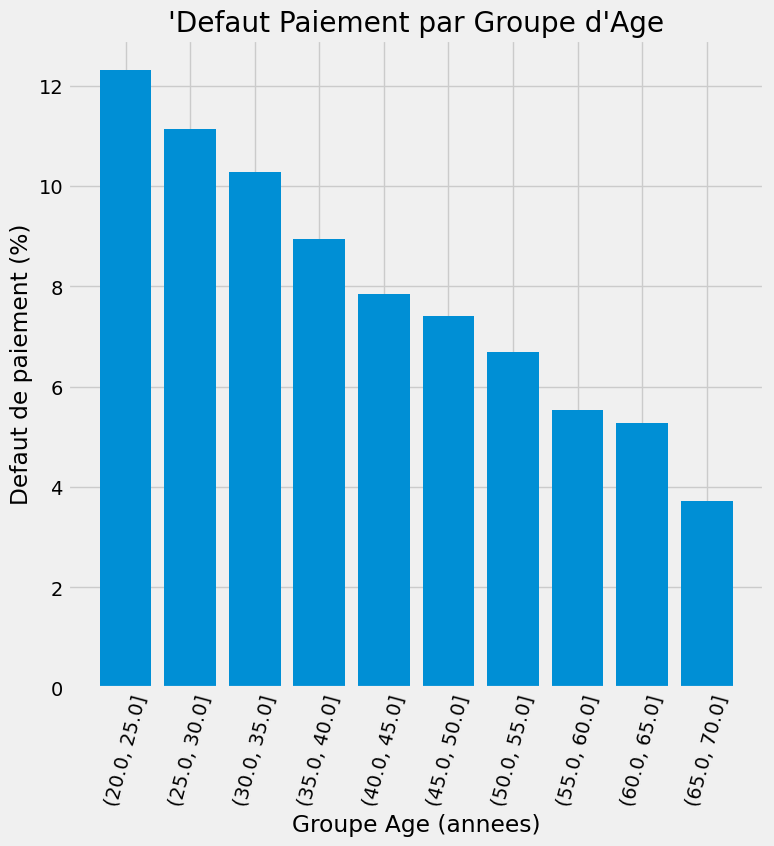

In [95]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Groupe Age (annees)'); plt.ylabel('Defaut de paiement (%)')
plt.title("'Defaut Paiement par Groupe d'Age")

### EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

In [97]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

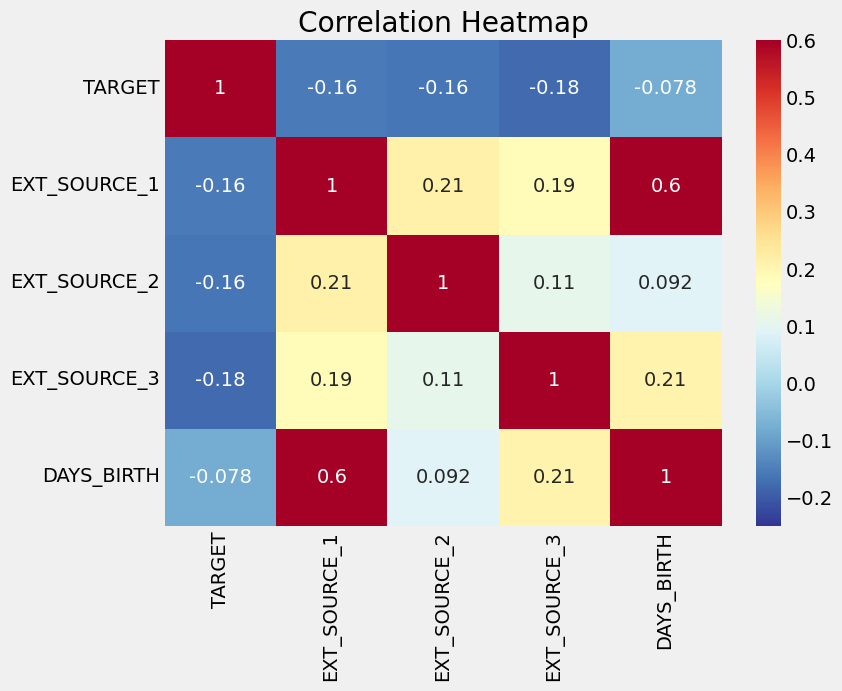

In [98]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

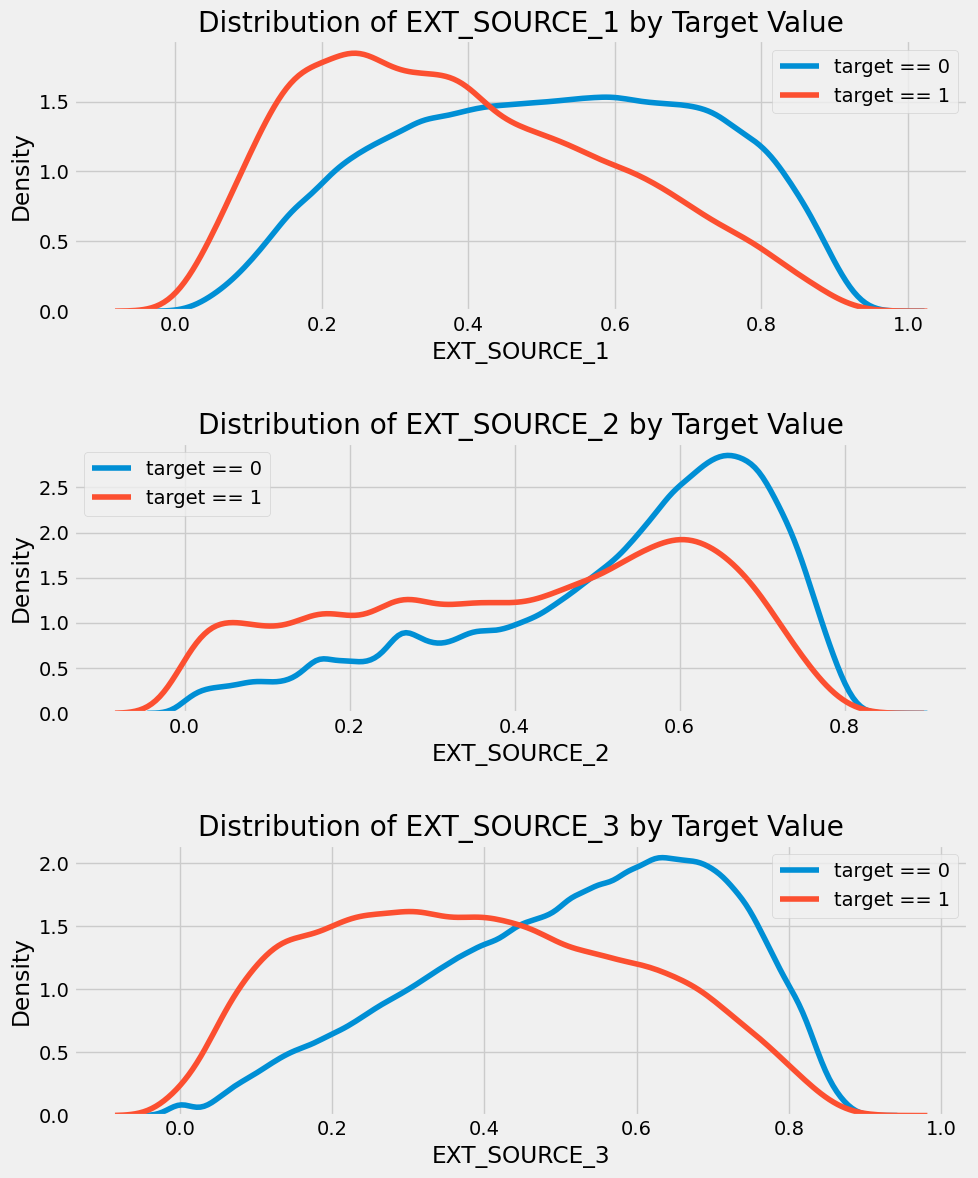

In [108]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)
    

### Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income 
ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income 
CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due 
DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age 

Again, thanks to Aguiar and his great script for exploring these features.

In [110]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

In [120]:
app_train

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1                   0             0                1   
1           100003       0                   0             0                0   
2           100004       0                   1             1                1   
3           100006       0                   0             0                1   
4           100007       0                   0             0                1   
...            ...     ...                 ...           ...              ...   
307506      456251       0                   0             0                0   
307507      456252       0                   0             0                1   
307508      456253       0                   0             0                1   
307509      456254       1                   0             0                1   
307510      456255       0                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Panel  \
0              351000.0  ...                         0   
1             1129500.0  ...                         0   
2              135000.0  ...                         0   
3              297000.0  ...                         0   
4              513000.0  ...                         0   
...                 ...  ...                       ...   
307506         225000.0  ...                         0   
307507         225000.0  ...                         0   
307508         585000.0  ...                         1   
307509         319500.0  ...                         0   
307510         675000.0  ...                         1   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                     1                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   
...                                 ...                        ...   
307506                                1                          0   
307507                                1                          0   
307508                                0                          0   
307509                                1                          0   
307510                                0                          0   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_ANOM  \
0                            1                        0               False   
1                            1                        0               False   
2                            0                        0               False   
3                            0                        0               False   
4                            0                        0               False   
...                        ...                      ...                 ...   
307506                       1                        0               False   
307507                       1                        0     

## Dataset complet et feature engineering

In [3]:
# Chargement des librairies
import gc
import re
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [7]:
# run functions and pre_settings
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

def do_sum(dataframe, group_cols, counted, agg_name):
    gp = dataframe[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted: agg_name})
    dataframe = dataframe.merge(gp, on=group_cols, how='left')
    return dataframe

def reduce_mem_usage(dataframe):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

    m_end = dataframe.memory_usage().sum() / 1024 ** 2
    return dataframe

nan_as_category = True

In [9]:
# Charger les datasets
train_df = pd.read_csv(r'application_train_init.csv')
test_df = pd.read_csv(r'application_test_init.csv')


In [11]:
# Ajouter une colonne d'identification pour différencier train et test
train_df['is_train'] = 1
test_df['is_train'] = 0


In [13]:
# Concaténer les deux datasets
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [15]:
# Effectuer les traitements et transformations sur le dataset combiné
def application(df):
    # Nettoyage général
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Supprime les outliers
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
    
    # Encodage binaire
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
    
    # One-Hot encoding pour les variables catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category=True)
    
    # Ajout de nouvelles features
    df['DOCUMENT_COUNT'] = df[[f for f in df.columns if 'FLAG_DOC' in f]].sum(axis=1)
    df['NEW_DOC_KURT'] = df[[f for f in df.columns if 'FLAG_DOC' in f]].kurtosis(axis=1)
    
    # Catégorisation de l'âge
    def get_age_label(days_birth):
        age_years = -days_birth / 365
        if age_years < 27: return 1
        elif age_years < 40: return 2
        elif age_years < 50: return 3
        elif age_years < 65: return 4
        elif age_years < 99: return 5
        else: return 0
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))
    
    # Ajout de ratio et autres features basés sur EXT_SOURCE
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df['EXT_SOURCE_1'] * 2 + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3'] * 3
    df['EXT_SOURCES_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
    df['EXT_SOURCES_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
    
    # Ratios supplémentaires
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Ratios de crédit et revenu
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

    # Ratios temporels
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Autres features basées sur EXT_SOURCE
    df['APPS_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1).fillna(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1).mean())

    # Ratios additionnels pour EXT_SOURCE
    df['APP_SCORE1_TO_BIRTH_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE2_TO_BIRTH_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE3_TO_BIRTH_RATIO'] = df['EXT_SOURCE_3'] / (df['DAYS_BIRTH'] / 365.25)

    df['APP_SCORE1_TO_EMPLOY_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_EMPLOYED'] / 365.25)
    df['APP_EXT_SOURCE_1*EXT_SOURCE_2*DAYS_BIRTH'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['DAYS_BIRTH']
    df['APP_SCORE1_TO_FAM_CNT_RATIO'] = df['EXT_SOURCE_1'] / df['CNT_FAM_MEMBERS']
    df['APP_SCORE1_TO_GOODS_RATIO'] = df['EXT_SOURCE_1'] / df['AMT_GOODS_PRICE']
    df['APP_SCORE1_TO_CREDIT_RATIO'] = df['EXT_SOURCE_1'] / df['AMT_CREDIT']
    df['APP_SCORE1_TO_SCORE2_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['APP_SCORE1_TO_SCORE3_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']
    df['APP_SCORE2_TO_CREDIT_RATIO'] = df['EXT_SOURCE_2'] / df['AMT_CREDIT']
    df['APP_SCORE2_TO_REGION_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']

    # Features de ratio final
    df['APPS_GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['APPS_CNT_FAM_INCOME_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['APPS_INCOME_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    
    print('"Application_Train_Test" final shape:', df.shape)
    return df
    


In [16]:
# Appliquer la fonction de transformation
df = application(df)

"Application_Train_Test" final shape: (356250, 292)


In [19]:
df

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002     1.0            0             0                0   
1           100003     0.0            1             0                1   
2           100004     0.0            0             1                0   
3           100006     0.0            1             0                0   
4           100007     0.0            0             0                0   
...            ...     ...          ...           ...              ...   
356250      456221     NaN            1             0                0   
356251      456222     NaN            1             0                1   
356252      456223     NaN            1             1                0   
356253      456224     NaN            0             0                1   
356254      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356250             0          121500.0    412560.0      17473.5   
356251             2          157500.0    622413.0      31909.5   
356252             1          202500.0    315000.0      33205.5   
356253             0          225000.0    450000.0      25128.0   
356254             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  ...  APP_SCORE1_TO_FAM_CNT_RATIO  \
0              351000.0  ...                     0.083037   
1             1129500.0  ...                     0.155634   
2              135000.0  ...                          NaN   
3              297000.0  ...                          NaN   
4              513000.0  ...                          NaN   
...                 ...  ...                          ...   
356250         270000.0  ...                          NaN   
356251         495000.0  ...                          NaN   
356252         315000.0  ...                     0.244501   
356253         450000.0  ...                     0.186545   
356254         270000.0  ...                          NaN   

        APP_SCORE1_TO_GOODS_RATIO  APP_SCORE1_TO_CREDIT_RATIO  \
0                    2.365726e-07                2.042240e-07   
1                    2.755797e-07                2.406391e-07   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   
...                           ...                         ...   
356250                        NaN                         NaN   
356251                        NaN                         NaN   
356252               2.328583e-06                2.328583e-06   
356253               8.290891e-07                8.290891e-07   
356254                        NaN                         NaN   

        APP_SCORE1_TO_SCORE2_RATIO  APP_SCORE1_TO_SCORE3_RATIO  \
0                         0.315792                    0.595778   
1                         0.500232                         NaN   
2                              NaN                         NaN   
3                              NaN                         NaN   
4                              NaN                         NaN   
...                            ...                         ...   
356250                         NaN                         NaN   
356251                         NaN                         NaN   
356252                    1.159195                    2.585382   
356253                    0.837086                    0.626562   
356254                         NaN                         NaN   

       

In [21]:
def bureau_bb():
    bureau = pd.read_csv(r'bureau.csv')
    bb = pd.read_csv(r'bureau_balance.csv')

    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
    bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']

    # CREDIT_DAY_OVERDUE :
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 120 else 0)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    #Status of Credit Bureau loan during the month
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'min'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'SK_ID_BUREAU': ['count'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'ENDDATE_DIF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO': ['min', 'max', 'mean'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_IS_DPD': ['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120': ['mean', 'sum']
        }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    print('"Bureau/Bureau Balance" final shape:', bureau_agg.shape)
    return bureau_agg

In [23]:
def previous_application():
    prev = pd.read_csv(r'previous_application.csv')

    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']

    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment / prev['AMT_CREDIT'] - 1) / prev['CNT_PAYMENT']

    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # from off
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE'] / prev['AMT_APPLICATION']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'SK_ID_PREV': ['nunique'],
        'DAYS_TERMINATION': ['max'],
        'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
        'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'sum'],
        'DOWN_PAYMENT_TO_CREDIT': ['mean'],
        'PREV_GOODS_DIFF': ['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO': ['mean', 'max'],
        'DAYS_LAST_DUE_DIFF': ['mean', 'max', 'sum'],
        'SIMPLE_INTERESTS': ['mean', 'max']
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    print('"Previous Applications" final shape:', prev_agg.shape)
    return prev_agg

In [25]:
def pos_cash():
    pos = pd.read_csv(r'POS_CASH_balance.csv')

    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos['POS_IS_DPD'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0) # <-- same with ['LATE_PAYMENT']
    pos['POS_IS_DPD_UNDER_120'] = pos['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    pos['POS_IS_DPD_OVER_120'] = pos['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'min'],
        'SK_DPD': ['max', 'mean', 'sum', 'var', 'min'],
        'SK_DPD_DEF': ['max', 'mean', 'sum'],
        'SK_ID_PREV': ['nunique'],
        'LATE_PAYMENT': ['mean'],
        'SK_ID_CURR': ['count'],
        'CNT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean', 'sum'],
        'POS_IS_DPD': ['mean', 'sum'],
        'POS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'POS_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()


    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df_pos = pd.DataFrame()
    df_pos['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df_pos['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

    # Percentage of previous loans completed and completed before initial term
    df_pos['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = df_pos.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0 \
                                                                      and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df_pos['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df_pos['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()

    # Group by SK_ID_CURR and merge
    df_gp = df_pos.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')

    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR', 'LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    print('"Pos-Cash" balance final shape:', pos_agg.shape) 
    return pos_agg

In [27]:
def installment():
    ins = pd.read_csv(r'installments_payments.csv')

    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # Group payments and get Payment difference
    ins = do_sum(ins, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    ins['PAYMENT_DIFFERENCE'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT_GROUPED']
    ins['PAYMENT_RATIO'] = ins['AMT_INSTALMENT'] / ins['AMT_PAYMENT_GROUPED']
    ins['PAID_OVER_AMOUNT'] = ins['AMT_PAYMENT'] - ins['AMT_INSTALMENT']
    ins['PAID_OVER'] = (ins['PAID_OVER_AMOUNT'] > 0).astype(int)

    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    ins['DPD_diff'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD_diff'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD_diff'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD_diff'].apply(lambda x: x if x > 0 else 0)

    # Flag late payment
    ins['LATE_PAYMENT'] = ins['DBD'].apply(lambda x: 1 if x > 0 else 0)
    ins['INSTALMENT_PAYMENT_RATIO'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['LATE_PAYMENT_RATIO'] = ins.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    # Flag late payments that have a significant amount
    ins['SIGNIFICANT_LATE_PAYMENT'] = ins['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    
    # Flag k threshold late payments
    ins['DPD_7'] = ins['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    ins['DPD_15'] = ins['DPD'].apply(lambda x: 1 if x >= 15 else 0)

    ins['INS_IS_DPD_UNDER_120'] = ins['DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    ins['INS_IS_DPD_OVER_120'] = ins['DPD'].apply(lambda x: 1 if (x >= 120) else 0)

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum', 'var'],
        'DBD': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum', 'min'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'min'],
        'SK_ID_PREV': ['size', 'nunique'],
        'PAYMENT_DIFFERENCE': ['mean'],
        'PAYMENT_RATIO': ['mean', 'max'],
        'LATE_PAYMENT': ['mean', 'sum'],
        'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'DPD_7': ['mean'],
        'DPD_15': ['mean'],
        'PAID_OVER': ['mean'],
        'DPD_diff':['mean', 'min', 'max'],
        'DBD_diff':['mean', 'min', 'max'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # from oof (DAYS_ENTRY_PAYMENT)
    cond_day = ins['DAYS_ENTRY_PAYMENT'] >= -365
    ins_d365_grp = ins[cond_day].groupby('SK_ID_CURR')
    ins_d365_agg_dict = {
        'SK_ID_CURR': ['count'],
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DAYS_ENTRY_PAYMENT': ['mean', 'max', 'sum'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_PAYMENT': ['mean', 'max', 'sum'],
        'PAYMENT_DIFF': ['mean', 'min', 'max', 'sum'],
        'PAYMENT_PERC': ['mean', 'max'],
        'DPD_diff': ['mean', 'min', 'max'],
        'DPD': ['mean', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum']}

    ins_d365_agg = ins_d365_grp.agg(ins_d365_agg_dict)
    ins_d365_agg.columns = ['INS_D365' + ('_').join(column).upper() for column in ins_d365_agg.columns.ravel()]

    ins_agg = ins_agg.merge(ins_d365_agg, on='SK_ID_CURR', how='left')

    print('"Installments Payments" final shape:', ins_agg.shape)
    return ins_agg

In [29]:
def credit_card():    
    cc = pd.read_csv(r'credit_card_balance.csv')

    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment <-- 'CARD_IS_DPD'
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

    cc['CARD_IS_DPD_UNDER_120'] = cc['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    cc['CARD_IS_DPD_OVER_120'] = cc['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    # General aggregations
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    CREDIT_CARD_TIME_AGG = {
        'AMT_BALANCE': ['mean', 'max'],
        'LIMIT_USE': ['max', 'mean'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum', 'mean'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        'LIMIT_USE': ['min', 'max'],
        'DRAWING_LIMIT_RATIO': ['min', 'max'],
        'LATE_PAYMENT': ['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120': ['mean', 'sum'],
        'CARD_IS_DPD_OVER_120': ['mean', 'sum']
    }

    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)


    print('"Credit Card Balance" final shape:', cc_agg.shape)
    return cc_agg

In [31]:
df = df.merge(bureau_bb(), how='left', on='SK_ID_CURR')
print('--=> df after merge with bureau:', df.shape)

"Bureau/Bureau Balance" final shape: (305811, 200)
--=> df after merge with bureau: (356250, 492)


In [32]:
df = df.merge(previous_application(), how='left', on='SK_ID_CURR')
print('--=> df after merge with previous application:', df.shape)

"Previous Applications" final shape: (338857, 321)
--=> df after merge with previous application: (356250, 813)


In [35]:
df = df.merge(pos_cash(), how='left', on='SK_ID_CURR')
print('--=> df after merge with pos cash :', df.shape)

"Pos-Cash" balance final shape: (337252, 46)
--=> df after merge with pos cash : (356250, 858)


In [37]:
df = df.merge(installment(), how='left', on='SK_ID_CURR')
print('--=> df after merge with installments:', df.shape)

"Installments Payments" final shape: (339587, 85)
--=> df after merge with installments: (356250, 943)


In [39]:
df = df.merge(credit_card(), how='left', on='SK_ID_CURR')
print('--=> df after merge with credit card:', df.shape)

"Credit Card Balance" final shape: (103558, 284)
--=> df after merge with credit card: (356250, 1226)


In [41]:
# Réduction de la consommation de mémoire 
df = reduce_mem_usage(df)
print('data types are converted for a reduced memory usage')


data types are converted for a reduced memory usage


In [43]:
# Renommage des colonnes  
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
print('names of feature are renamed')

names of feature are renamed


In [45]:
# Afficher df
df

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002     1.0            0             0                0   
1           100003     0.0            1             0                1   
2           100004     0.0            0             1                0   
3           100006     0.0            1             0                0   
4           100007     0.0            0             0                0   
...            ...     ...          ...           ...              ...   
356245      456221     NaN            1             0                0   
356246      456222     NaN            1             0                1   
356247      456223     NaN            1             1                0   
356248      456224     NaN            0             0                1   
356249      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356245             0          121500.0    412560.0      17473.5   
356246             2          157500.0    622413.0      31909.5   
356247             1          202500.0    315000.0      33205.5   
356248             0          225000.0    450000.0      25128.0   
356249             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  ...  INS_48M_SK_DPD_MAX  INS_48M_SK_DPD_SUM  \
0              351000.0  ...                 NaN                 NaN   
1             1129500.0  ...                 NaN                 NaN   
2              135000.0  ...                 NaN                 NaN   
3              297000.0  ...                 0.0                 0.0   
4              513000.0  ...                 NaN                 NaN   
...                 ...  ...                 ...                 ...   
356245         270000.0  ...                 NaN                 NaN   
356246         495000.0  ...                 NaN                 NaN   
356247         315000.0  ...                 NaN                 NaN   
356248         450000.0  ...                 NaN                 NaN   
356249         270000.0  ...                 0.0                 0.0   

        INS_48M_DRAWING_LIMIT_RATIO_MIN  INS_48M_DRAWING_LIMIT_RATIO_MAX  \
0                                   NaN                              NaN   
1                                   NaN                              NaN   
2                                   NaN                              NaN   
3                                   NaN                              NaN   
4                                   NaN                              NaN   
...                                 ...                              ...   
356245                              NaN                              NaN   
356246                              NaN                              NaN   
356247                              NaN                              NaN   
356248                              NaN                              NaN   
356249                              0.0                             0.95   

        INS_48M_LATE_PAYMENT_MEAN  INS_48M_LATE_PAYMENT_SUM  \
0                             NaN                       NaN   
1                             NaN                       NaN   
2                             NaN                       NaN   
3                             0.0                       0.0   
4                             NaN                       NaN   
...                           ...                       ...   
356245                        NaN                       NaN   
356246                        Na

In [47]:
# Vérifier les colonnes avec une valeur unique
single_value_columns = [col for col in df.columns if df[col].nunique() == 1]

print(single_value_columns)
print(len(single_value_columns))

['NAME_CONTRACT_TYPE_nan', 'NAME_INCOME_TYPE_nan', 'NAME_EDUCATION_TYPE_nan', 'NAME_FAMILY_STATUS_nan', 'NAME_HOUSING_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_nan', 'ORGANIZATION_TYPE_nan', 'BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'APPROVED_PREV_GOODS_DIFF_MEAN', 'APPROVED_PREV_GOODS_DIFF_MAX', 'APPROVED_PREV_GOODS_DIFF_SUM', 'APPROVED_PREV_GOODS_APPL_RATIO_MEAN', 'APPROVED_PREV_GOODS_APPL_RATIO_MAX', 'R

In [49]:
# Supprimer les colonnes avec une valeur unique

df.drop(columns=single_value_columns, inplace=True)

In [51]:
df.shape

(356250, 1185)

In [53]:
# Calculer les valeurs manquantes
missing_values = df.isnull().sum()


# Calculer le pourcentage de valeurs manquantes
missing_percentage = (missing_values / len(df)) * 100


In [55]:
missing_values

SK_ID_CURR                                 0
TARGET                                 48744
CODE_GENDER                                0
FLAG_OWN_CAR                               0
FLAG_OWN_REALTY                            0
                                       ...  
INS_48M_LATE_PAYMENT_SUM              252692
INS_48M_CARD_IS_DPD_UNDER_120_MEAN    252692
INS_48M_CARD_IS_DPD_UNDER_120_SUM     252692
INS_48M_CARD_IS_DPD_OVER_120_MEAN     252692
INS_48M_CARD_IS_DPD_OVER_120_SUM      252692
Length: 1185, dtype: int64

In [57]:
missing_percentage

SK_ID_CURR                             0.000000
TARGET                                13.682526
CODE_GENDER                            0.000000
FLAG_OWN_CAR                           0.000000
FLAG_OWN_REALTY                        0.000000
                                        ...    
INS_48M_LATE_PAYMENT_SUM              70.931088
INS_48M_CARD_IS_DPD_UNDER_120_MEAN    70.931088
INS_48M_CARD_IS_DPD_UNDER_120_SUM     70.931088
INS_48M_CARD_IS_DPD_OVER_120_MEAN     70.931088
INS_48M_CARD_IS_DPD_OVER_120_SUM      70.931088
Length: 1185, dtype: float64

In [59]:

# Calculer le seuil de valeurs manquantes
threshold = 0.50 * len(df)

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
df_cleaned = df.loc[:, df.isnull().sum() <= threshold]

# Afficher le DataFrame nettoyé
df_cleaned

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002     1.0            0             0                0   
1           100003     0.0            1             0                1   
2           100004     0.0            0             1                0   
3           100006     0.0            1             0                0   
4           100007     0.0            0             0                0   
...            ...     ...          ...           ...              ...   
356245      456221     NaN            1             0                0   
356246      456222     NaN            1             0                1   
356247      456223     NaN            1             1                0   
356248      456224     NaN            0             0                1   
356249      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356245             0          121500.0    412560.0      17473.5   
356246             2          157500.0    622413.0      31909.5   
356247             1          202500.0    315000.0      33205.5   
356248             0          225000.0    450000.0      25128.0   
356249             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  ...  INS_D365PAYMENT_PERC_MAX  INS_D365DPD_DIFF_MEAN  \
0              351000.0  ...                       1.0             -17.359375   
1             1129500.0  ...                       NaN                    NaN   
2              135000.0  ...                       NaN                    NaN   
3              297000.0  ...                       1.0              -6.183594   
4              513000.0  ...                       1.0              -2.250000   
...                 ...  ...                       ...                    ...   
356245         270000.0  ...                       NaN                    NaN   
356246         495000.0  ...                       1.0              -2.857422   
356247         315000.0  ...                       1.0             -22.000000   
356248         450000.0  ...                       1.0              -8.250000   
356249         270000.0  ...                       1.0              -9.531250   

        INS_D365DPD_DIFF_MIN  INS_D365DPD_DIFF_MAX  INS_D365DPD_MEAN  \
0                      -24.0                 -12.0          0.000000   
1                        NaN                   NaN               NaN   
2                        NaN                   NaN               NaN   
3                      -23.0                  -1.0          0.000000   
4                       -4.0                   0.0          0.000000   
...                      ...                   ...               ...   
356245                   NaN                   NaN               NaN   
356246                 -10.0                   2.0          0.142822   
356247                 -22.0                 -22.0          0.000000   
356248                 -12.0                  -5.0          0.000000   
356249                 -30.0                  10.0          0.625000   

        INS_D365DPD_SUM  INS_D365INS_IS_DPD_UNDER_120_MEAN  \
0                   0.0                           0.000000   
1                   NaN                                NaN   
2                   NaN                                NaN   
3                   0.0                           0.000000   
4                   0.0                           0.000000   
...                 ...                                ...   
356245              NaN                   

In [63]:
import pandas as pd

# Permet d'afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher les colonnes
df_cleaned.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'INS_D365PAYMENT_PERC_MAX', 'INS_D365DPD_DIFF_MEAN',
       'INS_D365DPD_DIFF_MIN', 'INS_D365DPD_DIFF_MAX', 'INS_D365DPD_MEAN',
       'INS_D365DPD_SUM', 'INS_D365INS_IS_DPD_UNDER_120_MEAN',
       'INS_D365INS_IS_DPD_UNDER_120_SUM', 'INS_D365INS_IS_DPD_OVER_120_MEAN',
       'INS_D365INS_IS_DPD_OVER_120_SUM'],
      dtype='object', length=774)

In [65]:
df_cleaned.shape

(356250, 774)

In [67]:
df_cleaned.dtypes

SK_ID_CURR                             int32
TARGET                               float16
CODE_GENDER                             int8
FLAG_OWN_CAR                            int8
FLAG_OWN_REALTY                         int8
                                      ...   
INS_D365DPD_SUM                      float32
INS_D365INS_IS_DPD_UNDER_120_MEAN    float16
INS_D365INS_IS_DPD_UNDER_120_SUM     float16
INS_D365INS_IS_DPD_OVER_120_MEAN     float16
INS_D365INS_IS_DPD_OVER_120_SUM      float16
Length: 774, dtype: object

## Séparation datasets 'application_train' et 'application_test'

In [70]:
# Séparer à nouveau train et test après transformations
train_df = df_cleaned[df_cleaned['is_train'] == 1].drop(columns=['is_train'])
test_df = df_cleaned[df_cleaned['is_train'] == 0].drop(columns=['is_train'])

In [72]:
test_df

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
307506      100001     NaN            1             0                0   
307507      100005     NaN            0             0                0   
307508      100013     NaN            0             1                0   
307509      100028     NaN            1             0                0   
307510      100038     NaN            0             1                1   
...            ...     ...          ...           ...              ...   
356245      456221     NaN            1             0                0   
356246      456222     NaN            1             0                1   
356247      456223     NaN            1             1                0   
356248      456224     NaN            0             0                1   
356249      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
307506             0          135000.0    568800.0      20560.5   
307507             0           99000.0    222768.0      17370.0   
307508             0          202500.0    663264.0      69777.0   
307509             2          315000.0   1575000.0      49018.5   
307510             1          180000.0    625500.0      32067.0   
...              ...               ...         ...          ...   
356245             0          121500.0    412560.0      17473.5   
356246             2          157500.0    622413.0      31909.5   
356247             1          202500.0    315000.0      33205.5   
356248             0          225000.0    450000.0      25128.0   
356249             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
307506         450000.0                    0.018845      -19241   
307507         180000.0                    0.035797      -18064   
307508         630000.0                    0.019104      -20038   
307509        1575000.0                    0.026398      -13976   
307510         625500.0                    0.010033      -13040   
...                 ...                         ...         ...   
356245         270000.0                    0.002043      -19970   
356246         495000.0                    0.035797      -11186   
356247         315000.0                    0.026398      -15922   
356248         450000.0                    0.018845      -13968   
356249         270000.0                    0.006630      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
307506        -2328.0            -5168.0             -812           1   
307507        -4468.0            -9120.0            -1623           1   
307508        -4456.0            -2176.0            -3503           1   
307509        -1866.0            -2000.0            -4208           1   
307510        -2192.0            -4000.0            -4262           1   
...               ...                ...              ...         ...   
356245        -5168.0            -9096.0            -3399           1   
356246        -1149.0            -3016.0            -3003           1   
356247        -3036.0            -2680.0            -1504           1   
356248        -2732.0            -1461.0            -1364           1   
356249         -633.0            -1072.0            -4220           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
307506               1                0                 1           0   
307507               1                0                 1           0   
307508               1                0                 1           0   
307509               1                0                 1           1   
307510               1                1                 1           0   
...                ...              ...               ...         ...   
356245               1                1                 1           1   
356246               1                0         

In [73]:
train_df

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002     1.0            0             0                0   
1           100003     0.0            1             0                1   
2           100004     0.0            0             1                0   
3           100006     0.0            1             0                0   
4           100007     0.0            0             0                0   
...            ...     ...          ...           ...              ...   
307501      456251     0.0            0             0                1   
307502      456252     0.0            1             0                0   
307503      456253     0.0            1             0                0   
307504      456254     1.0            1             0                0   
307505      456255     0.0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307501             0          157500.0    254700.0      27558.0   
307502             0           72000.0    269550.0      12001.5   
307503             0          153000.0    677664.0      29979.0   
307504             0          171000.0    370107.0      20205.0   
307505             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018799       -9461   
1             1129500.0                    0.003542      -16765   
2              135000.0                    0.010033      -19046   
3              297000.0                    0.008018      -19005   
4              513000.0                    0.028656      -19932   
...                 ...                         ...         ...   
307501         225000.0                    0.032562       -9327   
307502         225000.0                    0.025162      -20775   
307503         585000.0                    0.005001      -14966   
307504         319500.0                    0.005314      -11961   
307505         675000.0                    0.046234      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2              -225.0            -4260.0            -2531           1   
3             -3040.0            -9832.0            -2437           1   
4             -3038.0            -4312.0            -3458           1   
...               ...                ...              ...         ...   
307501         -236.0            -8456.0            -1982           1   
307502            NaN            -4388.0            -4090           1   
307503        -7920.0            -6736.0            -5150           1   
307504        -4784.0            -2562.0             -931           1   
307505        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
307501               1                0                 1           0   
307502               0                0         

In [76]:
# Afficher les formes finales
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (307506, 773)
Test shape: (48744, 773)


In [78]:
# Sauvegarder les dataframes train_df et test_df
train_df.to_csv('application_train.csv')
test_df.to_csv('application_test.csv')

In [80]:
df_cleaned.dtypes

SK_ID_CURR                             int32
TARGET                               float16
CODE_GENDER                             int8
FLAG_OWN_CAR                            int8
FLAG_OWN_REALTY                         int8
                                      ...   
INS_D365DPD_SUM                      float32
INS_D365INS_IS_DPD_UNDER_120_MEAN    float16
INS_D365INS_IS_DPD_UNDER_120_SUM     float16
INS_D365INS_IS_DPD_OVER_120_MEAN     float16
INS_D365INS_IS_DPD_OVER_120_SUM      float16
Length: 774, dtype: object

In [82]:
# Remplace les valeurs infinies par NaN
df_cleaned['TARGET'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [84]:
# Convertit la colonne en type texte pour accepter "non renseigné"
df_cleaned['TARGET'] = df_cleaned['TARGET'].astype(object)


In [88]:
df_cleaned.dtypes

SK_ID_CURR                             int32
TARGET                                object
CODE_GENDER                             int8
FLAG_OWN_CAR                            int8
FLAG_OWN_REALTY                         int8
                                      ...   
INS_D365DPD_SUM                      float32
INS_D365INS_IS_DPD_UNDER_120_MEAN    float16
INS_D365INS_IS_DPD_UNDER_120_SUM     float16
INS_D365INS_IS_DPD_OVER_120_MEAN     float16
INS_D365INS_IS_DPD_OVER_120_SUM      float16
Length: 774, dtype: object

In [90]:
# Remplace les NaN par "non renseigné"
df_cleaned['TARGET'].fillna("non renseigné", inplace=True)

In [92]:
df_cleaned

SK_ID_CURR         TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002            1.0            0             0                0   
1           100003            0.0            1             0                1   
2           100004            0.0            0             1                0   
3           100006            0.0            1             0                0   
4           100007            0.0            0             0                0   
...            ...            ...          ...           ...              ...   
356245      456221  non renseigné            1             0                0   
356246      456222  non renseigné            1             0                1   
356247      456223  non renseigné            1             1                0   
356248      456224  non renseigné            0             0                1   
356249      456250  non renseigné            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356245             0          121500.0    412560.0      17473.5   
356246             2          157500.0    622413.0      31909.5   
356247             1          202500.0    315000.0      33205.5   
356248             0          225000.0    450000.0      25128.0   
356249             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018799       -9461   
1             1129500.0                    0.003542      -16765   
2              135000.0                    0.010033      -19046   
3              297000.0                    0.008018      -19005   
4              513000.0                    0.028656      -19932   
...                 ...                         ...         ...   
356245         270000.0                    0.002043      -19970   
356246         495000.0                    0.035797      -11186   
356247         315000.0                    0.026398      -15922   
356248         450000.0                    0.018845      -13968   
356249         270000.0                    0.006630      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2              -225.0            -4260.0            -2531           1   
3             -3040.0            -9832.0            -2437           1   
4             -3038.0            -4312.0            -3458           1   
...               ...                ...              ...         ...   
356245        -5168.0            -9096.0            -3399           1   
356246        -1149.0            -3016.0            -3003           1   
356247        -3036.0            -2680.0            -1504           1   
356248        -2732.0            -1461.0            -1364           1   
356249         -633.0            -1072.0            -4220           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
356245               1               

In [94]:
# Déterminer les features très corrélées (>80%)
def find_highly_correlated_columns(df_cleaned, threshold=0.8):
    # Extraire uniquement les colonnes numériques
    numeric_df = df_cleaned.select_dtypes(include=[np.number])

    # Calculer la matrice de corrélation
    corr_matrix = numeric_df.corr()

    # Créer un masque pour la matrice de corrélation (pour éviter de doubler les paires)
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Appliquer le masque et extraire les corrélations supérieures au seuil
    high_corr_pairs = corr_matrix.where(mask).stack().reset_index()
    high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    
    # Filtrer les paires ayant une corrélation absolue supérieure au seuil
    high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'].abs() > threshold]
    
    return high_corr_pairs

# Utilisation de la fonction
correlated_columns = find_highly_correlated_columns(df_cleaned)
print(correlated_columns)


                    Feature_1                         Feature_2  Correlation
3097             CNT_CHILDREN                   CNT_FAM_MEMBERS     0.878911
4069         AMT_INCOME_TOTAL             INCOME_TO_BIRTH_RATIO    -0.895871
4618               AMT_CREDIT                   AMT_GOODS_PRICE     0.987161
7878               DAYS_BIRTH                         AGE_RANGE    -0.952450
8640            DAYS_EMPLOYED                DAYS_EMPLOYED_PERC    -0.954535
...                       ...                               ...          ...
297127  INS_D365DPD_DIFF_MEAN              INS_D365DPD_DIFF_MIN     0.865248
297129  INS_D365DPD_DIFF_MEAN                  INS_D365DPD_MEAN     0.964724
297133  INS_D365DPD_DIFF_MEAN  INS_D365INS_IS_DPD_OVER_120_MEAN     0.836193
297151       INS_D365DPD_MEAN  INS_D365INS_IS_DPD_OVER_120_MEAN     0.864688
297156        INS_D365DPD_SUM   INS_D365INS_IS_DPD_OVER_120_SUM     0.847754

[577 rows x 3 columns]


In [95]:
# Supprimer les features très corrélées (>80%)
def drop_correlated_features(df_cleaned, correlated_columns):
    # Liste des colonnes à supprimer
    columns_to_drop = set()

    # Parcourir les paires de colonnes corrélées
    for index, row in correlated_columns.iterrows():
        # Ajouter la deuxième colonne de chaque paire à la liste de suppression
        # (on peut choisir de supprimer la première ou la deuxième colonne)
        columns_to_drop.add(row['Feature_2'])

    # Supprimer les colonnes corrélées de la DataFrame
    df_cleaned_final = df_cleaned.drop(columns=columns_to_drop)

    return df_cleaned_final, columns_to_drop

# Utilisation de la fonction
df_cleaned_final, columns_dropped = drop_correlated_features(df_cleaned, correlated_columns)

# Afficher les colonnes supprimées
print(f"Colonnes supprimées : {columns_dropped}")

# Afficher la DataFrame finale après suppression
print("DataFrame finale après suppression des features corrélées :")
df_cleaned_final

Colonnes supprimées : {'BURO_AMT_CREDIT_SUM_SUM', 'INS_D365INS_IS_DPD_OVER_120_SUM', 'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_AMT_GOODS_PRICE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'APPROVED_AMT_ANNUITY_MEAN', 'APPROVED_APPLICATION_CREDIT_DIFF_MIN', 'APPROVED_APPLICATION_CREDIT_DIFF_SUM', 'POS_POS_IS_DPD_OVER_120_MEAN', 'LIVINGAREA_MEDI', 'EMERGENCYSTATE_MODE_nan', 'ACTIVE_AMT_CREDIT_SUM_SUM', 'PREV_PRODUCT_COMBINATION_Cash_MEAN', 'APPROVED_DAYS_LAST_DUE_DIFF_MEAN', 'CNT_FAM_MEMBERS', 'BURO_BUREAU_CREDIT_ENDDATE_DIFF_MEAN', 'POS_MONTHS_BALANCE_MIN', 'APPS_EXT_SOURCE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'APPROVED_AMT_GOODS_PRICE_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_SUM', 'INS_D365DAYS_INSTALMENT_SUM', 'PREV_CHANNEL_TYPE_Car_dealer_MEAN', 'INCOME_TO_BIRTH_RATIO', 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MIN', 'PREV_AMT_CREDIT_MAX', 'APPROVED_RATE_DOWN_PAYMENT_MAX', 'APPROVED_DAYS_DECISION_MAX', 'POS_SK_ID_CURR_COUNT', 'POS_SK_DPD_VAR', 'A

SK_ID_CURR         TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002            1.0            0             0                0   
1           100003            0.0            1             0                1   
2           100004            0.0            0             1                0   
3           100006            0.0            1             0                0   
4           100007            0.0            0             0                0   
...            ...            ...          ...           ...              ...   
356245      456221  non renseigné            1             0                0   
356246      456222  non renseigné            1             0                1   
356247      456223  non renseigné            1             1                0   
356248      456224  non renseigné            0             0                1   
356249      456250  non renseigné            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356245             0          121500.0    412560.0      17473.5   
356246             2          157500.0    622413.0      31909.5   
356247             1          202500.0    315000.0      33205.5   
356248             0          225000.0    450000.0      25128.0   
356249             0          135000.0    312768.0      24709.5   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                         0.018799       -9461         -637.0   
1                         0.003542      -16765        -1188.0   
2                         0.010033      -19046         -225.0   
3                         0.008018      -19005        -3040.0   
4                         0.028656      -19932        -3038.0   
...                            ...         ...            ...   
356245                    0.002043      -19970        -5168.0   
356246                    0.035797      -11186        -1149.0   
356247                    0.026398      -15922        -3036.0   
356248                    0.018845      -13968        -2732.0   
356249                    0.006630      -13962         -633.0   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0                 -3648.0            -2120           1               1   
1                 -1186.0             -291           1               1   
2                 -4260.0            -2531           1               1   
3                 -9832.0            -2437           1               1   
4                 -4312.0            -3458           1               1   
...                   ...              ...         ...             ...   
356245            -9096.0            -3399           1               1   
356246            -3016.0            -3003           1               1   
356247            -2680.0            -1504           1               1   
356248            -1461.0            -1364           1               1   
356249            -1072.0            -4220           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0                     0                 1           1           0   
1                     0                 1           1           0   
2                     1                 1           1           0   
3                     0                 1           0           0   
4                     0                 1           0           0   
...                 ...               ...         ...         ...   
356245                1                 1           1           0   
356246  

In [98]:
# Vérifier le nombre de valeurs manquantes dans chaque colonne
missing_values = df_cleaned_final.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

Valeurs manquantes par colonne :
AMT_ANNUITY                              36
DAYS_EMPLOYED                         64648
EXT_SOURCE_2                            668
EXT_SOURCE_3                          69633
YEARS_BEGINEXPLUATATION_AVG          172862
                                      ...  
INS_D365DPD_DIFF_MEAN                105432
INS_D365DPD_DIFF_MAX                 105432
INS_D365DPD_SUM                      105432
INS_D365INS_IS_DPD_UNDER_120_MEAN    105432
INS_D365INS_IS_DPD_UNDER_120_SUM     105432
Length: 320, dtype: int64


In [100]:
# Sélectionner uniquement les colonnes numériques
numeric_df = df_cleaned_final.select_dtypes(include=[np.number])

# Vérifier si des valeurs infinies existent dans chaque colonne numérique
infinite_columns = numeric_df.columns[np.isinf(numeric_df).any()].tolist()

# Afficher les colonnes qui contiennent des valeurs infinies
if infinite_columns:
    print(f"Les colonnes suivantes contiennent des valeurs infinies : {infinite_columns}")
else:
    print("Aucune valeur infinie détectée dans le DataFrame.")


Les colonnes suivantes contiennent des valeurs infinies : ['INCOME_TO_EMPLOYED_RATIO', 'BURO_BUREAU_CREDIT_DEBT_RATIO_MIN', 'BURO_BUREAU_CREDIT_DEBT_RATIO_MAX', 'CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN', 'CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX', 'CLOSED_BUREAU_CREDIT_DEBT_RATIO_MEAN', 'PREV_APP_CREDIT_PERC_MAX', 'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN', 'PREV_CREDIT_TO_ANNUITY_RATIO_MAX', 'PREV_PREV_GOODS_APPL_RATIO_MEAN', 'PREV_SIMPLE_INTERESTS_MEAN', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_RATIO_MEAN']


In [102]:
# Sélectionner uniquement les colonnes numériques
numeric_df = df_cleaned_final.select_dtypes(include=[np.number])

# Dictionnaire pour stocker le nombre de valeurs infinies par colonne
infinite_counts = {}

# Parcourir chaque colonne numérique pour compter et remplacer les valeurs infinies
for col in numeric_df.columns:
    # Compter les valeurs infinies dans la colonne
    inf_count = np.isinf(df_cleaned_final[col]).sum()
    if inf_count > 0:
        infinite_counts[col] = inf_count
        # Remplacer les valeurs infinies par NaN
        df_cleaned_final[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# Afficher le nombre de valeurs infinies pour chaque colonne
if infinite_counts:
    print("Nombre de valeurs infinies par colonne (avant remplacement) :")
    for col, count in infinite_counts.items():
        print(f"{col}: {count}")
else:
    print("Aucune valeur infinie détectée dans le DataFrame.")


Nombre de valeurs infinies par colonne (avant remplacement) :
INCOME_TO_EMPLOYED_RATIO: 2
BURO_BUREAU_CREDIT_DEBT_RATIO_MIN: 2562
BURO_BUREAU_CREDIT_DEBT_RATIO_MAX: 1963
CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN: 109
CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX: 29
CLOSED_BUREAU_CREDIT_DEBT_RATIO_MEAN: 25
PREV_APP_CREDIT_PERC_MAX: 1
PREV_CREDIT_TO_ANNUITY_RATIO_MEAN: 2
PREV_CREDIT_TO_ANNUITY_RATIO_MAX: 13
PREV_PREV_GOODS_APPL_RATIO_MEAN: 2
PREV_SIMPLE_INTERESTS_MEAN: 26251
INSTAL_PAYMENT_PERC_MAX: 19
INSTAL_PAYMENT_RATIO_MEAN: 552


In [104]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = df_cleaned_final.select_dtypes(include=[np.number]).columns

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
df_cleaned_final[numeric_columns] = df_cleaned_final[numeric_columns].apply(lambda x: x.fillna(x.mean()))

# Vérification : Afficher le nombre de valeurs manquantes après remplissage
missing_values_after = df_cleaned_final.isnull().sum()
print("Nombre de valeurs manquantes par colonne après remplissage :")
print(missing_values_after[missing_values_after > 0])


Nombre de valeurs manquantes par colonne après remplissage :
DAYS_EMPLOYED                        64648
EXT_SOURCE_2                           668
EXT_SOURCE_3                         69633
YEARS_BEGINEXPLUATATION_AVG         172862
OBS_30_CNT_SOCIAL_CIRCLE              1050
                                     ...  
INS_D365SK_ID_CURR_COUNT            105432
INS_D365PAYMENT_PERC_MEAN           105432
INS_D365DPD_DIFF_MEAN               105432
INS_D365DPD_DIFF_MAX                105432
INS_D365INS_IS_DPD_UNDER_120_SUM    105432
Length: 92, dtype: int64


In [106]:
df_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356250 entries, 0 to 356249
Columns: 498 entries, SK_ID_CURR to INS_D365INS_IS_DPD_UNDER_120_SUM
dtypes: float16(258), float32(55), float64(13), int16(2), int32(1), int8(38), object(1), uint8(130)
memory usage: 350.6+ MB


In [108]:
df_cleaned_final

SK_ID_CURR         TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002            1.0            0             0                0   
1           100003            0.0            1             0                1   
2           100004            0.0            0             1                0   
3           100006            0.0            1             0                0   
4           100007            0.0            0             0                0   
...            ...            ...          ...           ...              ...   
356245      456221  non renseigné            1             0                0   
356246      456222  non renseigné            1             0                1   
356247      456223  non renseigné            1             1                0   
356248      456224  non renseigné            0             0                1   
356249      456250  non renseigné            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356245             0          121500.0    412560.0      17473.5   
356246             2          157500.0    622413.0      31909.5   
356247             1          202500.0    315000.0      33205.5   
356248             0          225000.0    450000.0      25128.0   
356249             0          135000.0    312768.0      24709.5   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                         0.018799       -9461         -637.0   
1                         0.003542      -16765        -1188.0   
2                         0.010033      -19046         -225.0   
3                         0.008018      -19005        -3040.0   
4                         0.028656      -19932        -3038.0   
...                            ...         ...            ...   
356245                    0.002043      -19970        -5168.0   
356246                    0.035797      -11186        -1149.0   
356247                    0.026398      -15922        -3036.0   
356248                    0.018845      -13968        -2732.0   
356249                    0.006630      -13962         -633.0   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0                 -3648.0            -2120           1               1   
1                 -1186.0             -291           1               1   
2                 -4260.0            -2531           1               1   
3                 -9832.0            -2437           1               1   
4                 -4312.0            -3458           1               1   
...                   ...              ...         ...             ...   
356245            -9096.0            -3399           1               1   
356246            -3016.0            -3003           1               1   
356247            -2680.0            -1504           1               1   
356248            -1461.0            -1364           1               1   
356249            -1072.0            -4220           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0                     0                 1           1           0   
1                     0                 1           1           0   
2                     1                 1           1           0   
3                     0                 1           0           0   
4                     0                 1           0           0   
...                 ...               ...         ...         ...   
356245                1                 1           1           0   
356246  

In [110]:
# Trouver les colonnes contenant uniquement les valeurs 0 et 1
binary_columns = [col for col in df_cleaned_final.select_dtypes(include=[np.number]).columns 
                  if df_cleaned_final[col].dropna().isin([0, 1]).all()]

print("Colonnes pouvant être interprétées comme booléennes :", binary_columns)


Colonnes pouvant être interprétées comme booléennes : ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'is_train', 'NAME_CONTRACT_TYPE_Cash_loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group_of_people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse_partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_TYPE_SUITE_nan', 'NAME_INCOME_T

In [112]:
# Vérifier les types de la colonne TARGET
print(df_cleaned_final['TARGET'].dtype)

# Vérifier les valeurs uniques dans la colonne TARGET
print(df_cleaned_final['TARGET'].unique())

# Vérifier les valeurs manquantes ou NaN
print(df_cleaned_final['TARGET'].isnull().sum())

# Vérifier les types de données dans toute la DataFrame
print(df_cleaned_final.dtypes)


object
[1.0 0.0 'non renseigné']
0
SK_ID_CURR                             int32
TARGET                                object
CODE_GENDER                             int8
FLAG_OWN_CAR                            int8
FLAG_OWN_REALTY                         int8
                                      ...   
INS_D365DPD_DIFF_MEAN                float16
INS_D365DPD_DIFF_MAX                 float16
INS_D365DPD_SUM                      float32
INS_D365INS_IS_DPD_UNDER_120_MEAN    float16
INS_D365INS_IS_DPD_UNDER_120_SUM     float16
Length: 498, dtype: object


In [114]:
# Remplacer 'non renseigné' par NaN
df_cleaned_final['TARGET'] = df_cleaned_final['TARGET'].replace('non renseigné', pd.NA)

# Convertir les autres valeurs en numériques (0 ou 1)
df_cleaned_final['TARGET'] = pd.to_numeric(df_cleaned_final['TARGET'], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes dans 'TARGET'
df_cleaned_final = df_cleaned_final.dropna(subset=['TARGET'])

print(df_cleaned_final['TARGET'].value_counts())


0.0    282682
1.0     24824
Name: TARGET, dtype: int64


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [120]:
# 1. Échantillonner les données pour entraîner le modèle
df_sample, _ = train_test_split(df_cleaned_final, train_size=10000, stratify=df_cleaned_final['TARGET'], random_state=42)


In [122]:
# Séparer les features et la cible
X_sample = df_sample.drop(columns=['TARGET', 'SK_ID_CURR'])
y_sample = df_sample['TARGET']

In [124]:
# 2. Imputer les valeurs manquantes dans les données échantillonnées
imputer = SimpleImputer(strategy='mean')
X_imputed_sample = imputer.fit_transform(X_sample)

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [134]:
# 3. Entraîner un modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_imputed_sample, y_sample)

RandomForestClassifier(random_state=42)

In [136]:
# 4. Extraire l'importance des features
feature_importances = rf_model.feature_importances_

In [138]:
# 5. Créer un DataFrame des importances des features avec leurs noms
feature_names = X_sample.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})


In [140]:
# 6. Trier les features par importance et sélectionner les 100 premières
top_100_features = feature_importance_df.sort_values(by='importance', ascending=False).head(100)['feature'].tolist()

In [142]:
top_100_features

['EXT_SOURCES_MIN',
 'EXT_SOURCES_MAX',
 'EXT_SOURCE_2',
 'APP_SCORE2_TO_REGION_RATING_RATIO',
 'EXT_SOURCE_3',
 'APP_SCORE2_TO_BIRTH_RATIO',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'APPS_EXT_SOURCE_STD',
 'DAYS_REGISTRATION',
 'INSTAL_AMT_INSTALMENT_MAX',
 'DAYS_ID_PUBLISH',
 'PAYMENT_RATE',
 'INSTAL_AMT_INSTALMENT_MEAN',
 'PREV_AMT_ANNUITY_MAX',
 'INS_D365DPD_DIFF_MAX',
 'PREV_DAYS_DECISION_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'INCOME_TO_EMPLOYED_RATIO',
 'INSTAL_DBD_VAR',
 'BURO_DAYS_CREDIT_MEAN',
 'INSTAL_AMT_INSTALMENT_MIN',
 'PREV_SIMPLE_INTERESTS_MEAN',
 'ANNUITY_INCOME_PERC',
 'PREV_AMT_ANNUITY_SUM',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_DEBT_CREDIT_DIFF_MAX',
 'BURO_DEBT_CREDIT_DIFF_MIN',
 'INCOME_CREDIT_PERC',
 'INS_D365AMT_INSTALMENT_MEAN',
 'INS_D365AMT_INSTALMENT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'BURO_BUREAU_CREDIT_FACT_DIFF_MAX',
 'INSTAL_DBD_SUM',
 'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN',
 'BURO_DAYS_CREDIT_MIN',
 'INCOME_PER_PERSON',
 'PREV_AMT_GOODS_PRICE_MIN',
 'INS_D365DPD_DI

In [144]:
# 7. Filtrer les colonnes importantes dans le dataframe original

columns_to_keep = top_100_features + ['CODE_GENDER']

In [148]:
# Créer le DataFrame final avec seulement les colonnes nécessaires
df_final = df_cleaned_final[['SK_ID_CURR', 'TARGET'] + columns_to_keep]

# Vérifier le résultat
df_final

SK_ID_CURR  TARGET  EXT_SOURCES_MIN  EXT_SOURCES_MAX  EXT_SOURCE_2  \
0           100002     1.0         0.083008         0.262939      0.262939   
1           100003     0.0         0.311279         0.622070      0.622070   
2           100004     0.0         0.556152         0.729492      0.556152   
3           100006     0.0         0.650391         0.650391      0.650391   
4           100007     0.0         0.322754         0.322754      0.322754   
...            ...     ...              ...              ...           ...   
307501      456251     0.0         0.145630         0.681641      0.681641   
307502      456252     0.0         0.115967         0.115967      0.115967   
307503      456253     0.0         0.218872         0.744141      0.535645   
307504      456254     1.0         0.514160         0.661133      0.514160   
307505      456255     0.0         0.113953         0.734375      0.708496   

        APP_SCORE2_TO_REGION_RATING_RATIO  EXT_SOURCE_3  \
0                                0.131470      0.139404   
1                                0.622070           NaN   
2                                0.278076      0.729492   
3                                0.325195           NaN   
4                                0.161377           NaN   
...                                   ...           ...   
307501                           0.681641           NaN   
307502                           0.057983           NaN   
307503                           0.178589      0.218872   
307504                           0.257080      0.661133   
307505                           0.708496      0.113953   

        APP_SCORE2_TO_BIRTH_RATIO  DAYS_EMPLOYED  DAYS_BIRTH  \
0                       -0.010155         -637.0       -9461   
1                       -0.013557        -1188.0      -16765   
2                       -0.010658         -225.0      -19046   
3                       -0.012497        -3040.0      -19005   
4                       -0.005913        -3038.0      -19932   
...                           ...            ...         ...   
307501                  -0.026688         -236.0       -9327   
307502                  -0.002039            NaN      -20775   
307503                  -0.013077        -7920.0      -14966   
307504                  -0.015701        -4784.0      -11961   
307505                  -0.015350        -1262.0      -16856   

        APPS_EXT_SOURCE_STD  DAYS_REGISTRATION  INSTAL_AMT_INSTALMENT_MAX  \
0                  0.092041            -3648.0               53093.746094   
1                  0.219849            -1186.0              560835.375000   
2                  0.122803            -4260.0               10573.964844   
3                  0.151001            -9832.0              691786.875000   
4                  0.151001            -4312.0               22678.785156   
...                     ...                ...                        ...   
307501             0.379150            -8456.0               12815.009766   
307502             0.151001            -4388.0               10074.464844   
307503             0.264404            -6736.0                5575.185059   
307504             0.103821            -2562.0               19065.824219   
307505             0.351074            -5128.0              615229.500000   

        DAYS_ID_PUBLISH  PAYMENT_RATE  INSTAL_AMT_INSTALMENT_MEAN  \
0                 -2120      0.060760                11559.247070   
1                  -291      0.027603                64754.585938   
2                 -2531      0.049988                 7096.154785   
3                 -2437      0.094971                62947.089844   
4                 -3458      0.042633                12666.444336   
...                 ...           ...                         ...   
307501            -1982      0.108215                 7492.924316   
307502            -4090      0.044525                10069.867188   
307503            -5150      0.044250          

In [150]:
# Sauvegarder le dataframe final avec les 101 features les plus importants, le TARGET et l' SK_ID_CURR
df_final.to_csv('df_final.csv')